# Проект: классификация

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [192]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes


In [193]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
# ваш код
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [195]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# ваш код
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [196]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
def make_convert(row):
    row = str(row)
    if row != 'unknown':
        row = row.replace(',00', '')
        row = row.replace('$', '')
        row = row.replace(' ', '')
        return float(row)
    else:
        return np.nan

df['balance'] = df['balance'].apply(make_convert)

round(df['balance'].mean(), 3)

1529.129

### Задание 4

In [197]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())
round(df['balance'].mean(), 3)

1526.936

### Задание 5

In [198]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
# ваш код
m_job = df['job'].mode()[0]
m_edu = df['education'].mode()[0]

df['job'] = df['job'].apply(lambda x: m_job if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: m_edu if x == 'unknown' else x)

df_popular = df[(df['job']== m_job) & (df['education'] == m_edu)]
round(df_popular['balance'].mean(), 3)


1598.883

### Задание 6

In [199]:
# удалите все выбросы для признака balance
per_25 = np.percentile(df['balance'], 25)
per_75 = np.percentile(df['balance'], 75)
iqr = per_75 - per_25
down_balance = per_25 - 1.5*iqr
upper_balance = per_75 + 1.5*iqr
clean_df = df[(df['balance'] >= down_balance) & (df['balance'] <= upper_balance)]
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  object 
 4   default    10105 non-null  object 
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  object 
 7   loan       10105 non-null  object 
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


## Часть 2:  Разведывательный анализ

### Задание 1

In [200]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
clean_df[clean_df['deposit']=='yes']['deposit'].value_counts()

yes    4681
Name: deposit, dtype: int64

<AxesSubplot: xlabel='deposit', ylabel='count'>

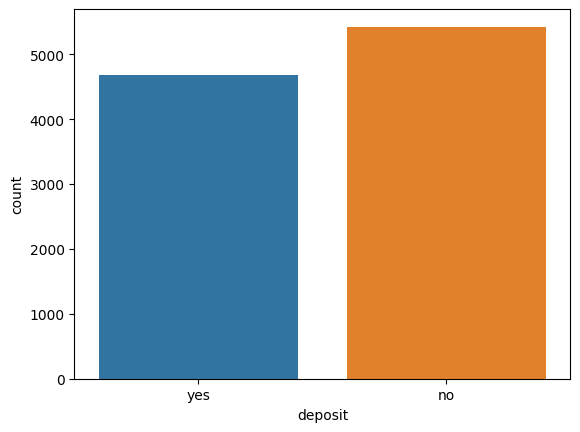

In [201]:
sns.countplot(x='deposit', data=clean_df)

### Задания 2 и 3

In [203]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
#ваш код
clean_df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


### Задания 4 и 5

In [204]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
#ваш код
clean_df.describe(include = 'object')
#постройте визуализации, иллюстрирующие результаты

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


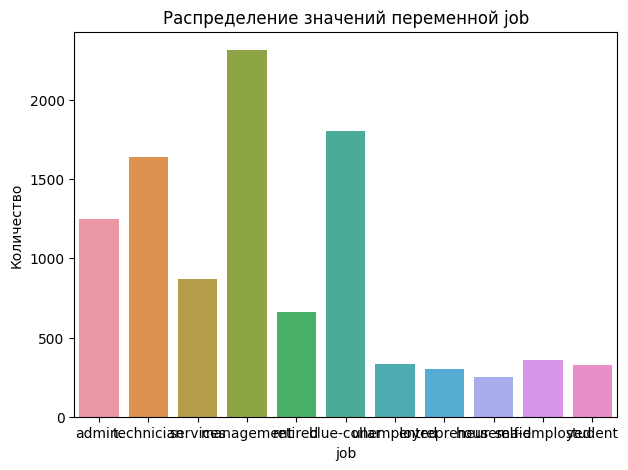

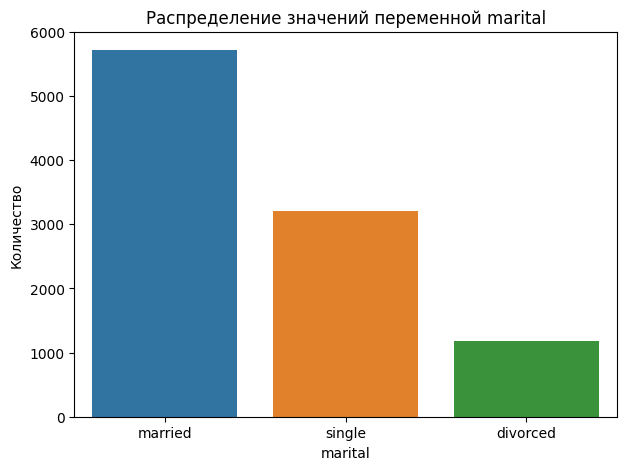

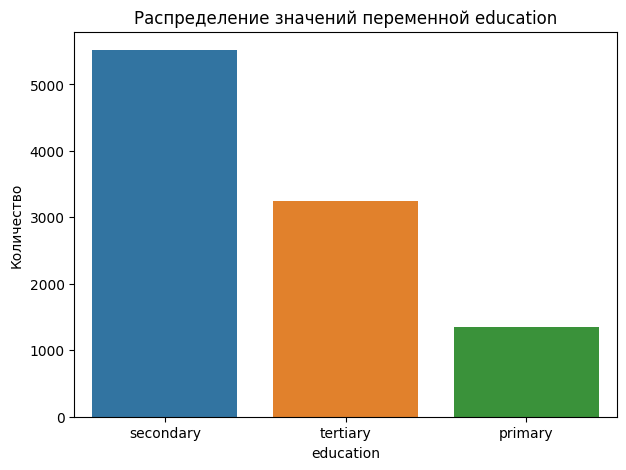

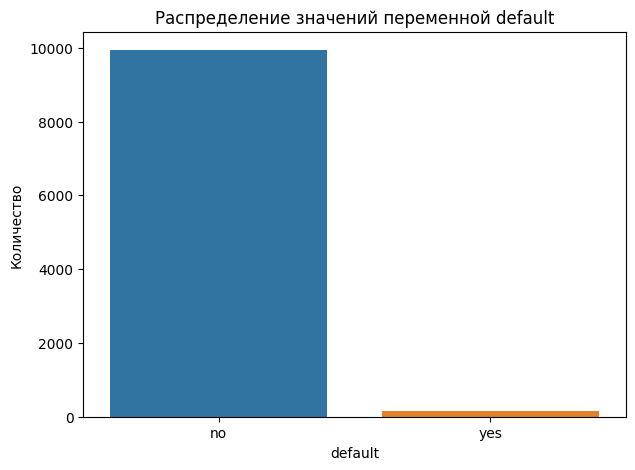

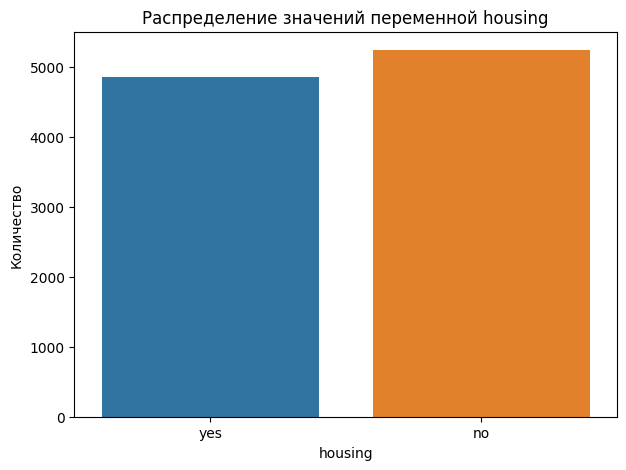

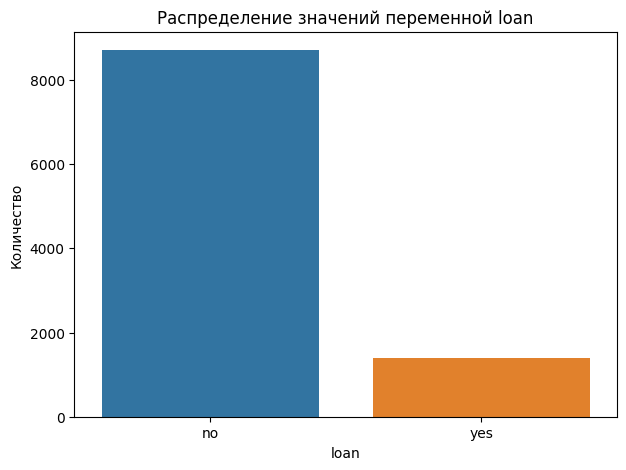

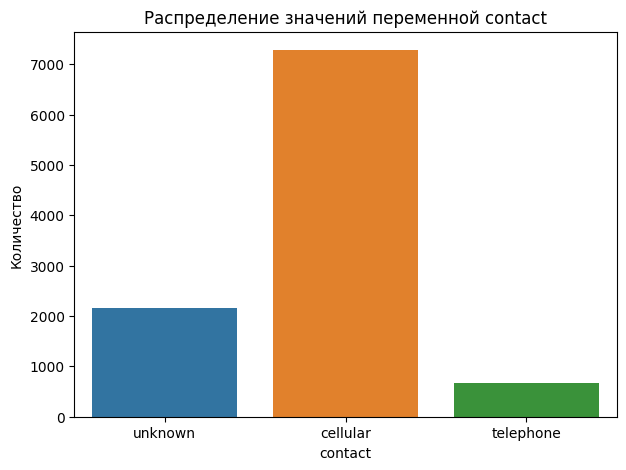

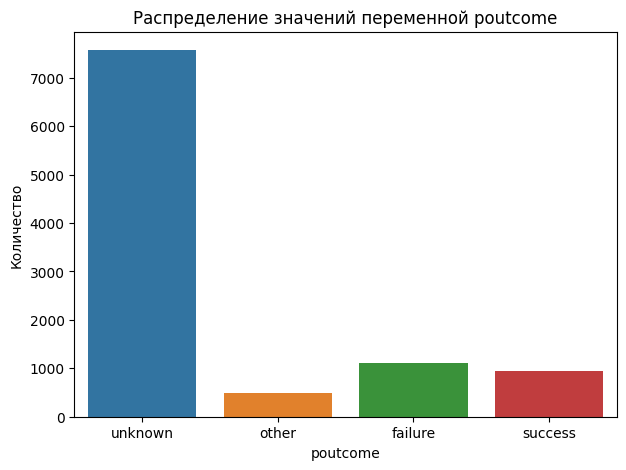

In [205]:
categorical_vars = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
# Визуализация количества уникальных значений
for var in categorical_vars:
    plt.figure(figsize=(7, 5))
    sns.countplot(x=var, data=clean_df)
    plt.title(f'Распределение значений переменной {var}')
    plt.xlabel(var)
    plt.ylabel('Количество')
    plt.show()


### Задание 6

<AxesSubplot: xlabel='poutcome'>

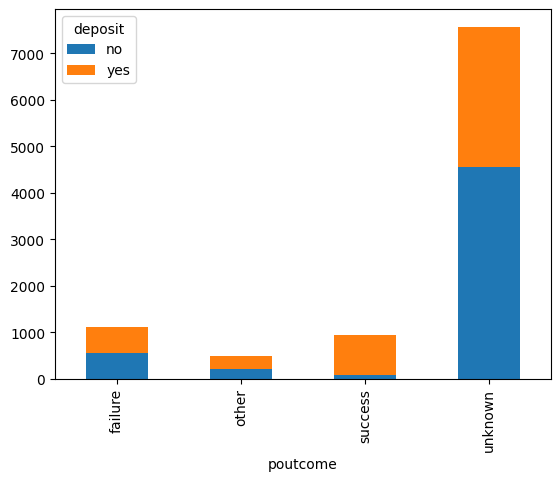

In [206]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# ваш код
types = clean_df.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()
types.plot(kind='bar', stacked='True')

### Задание 7

In [207]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# ваш код 
for i in np.unique(clean_df.month):
    print(i, clean_df[(clean_df.month == i)&(clean_df.deposit == 'no')].shape[0]/clean_df[(clean_df.month == i)].shape[0])


apr 0.3819277108433735
aug 0.5595667870036101
dec 0.0967741935483871
feb 0.45557122708039494
jan 0.6081504702194357
jul 0.5895627644569816
jun 0.5489130434782609
mar 0.10126582278481013
may 0.6786396637371036
nov 0.5846153846153846
oct 0.18507462686567164
sep 0.16546762589928057


### Задание 8

<AxesSubplot: xlabel='age_group', ylabel='count'>

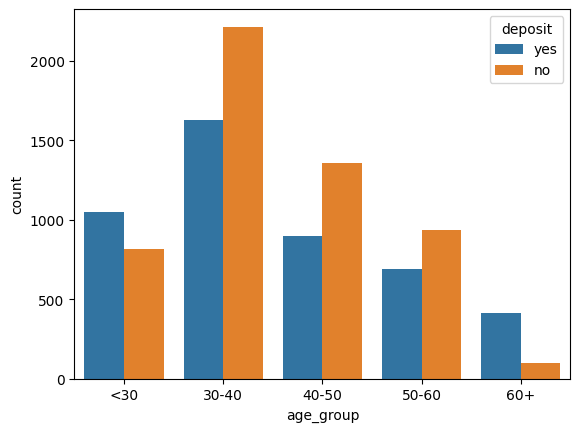

In [208]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
clean_df['age_group'] = pd.cut(clean_df.age, [0, 30, 40, 50, 60, 999], labels=['<30', '30-40', '40-50', '50-60', '60+'])
sns.countplot(x='age_group', hue='deposit', data=clean_df)

### Задания 9 и 10

<AxesSubplot: xlabel='count', ylabel='marital'>

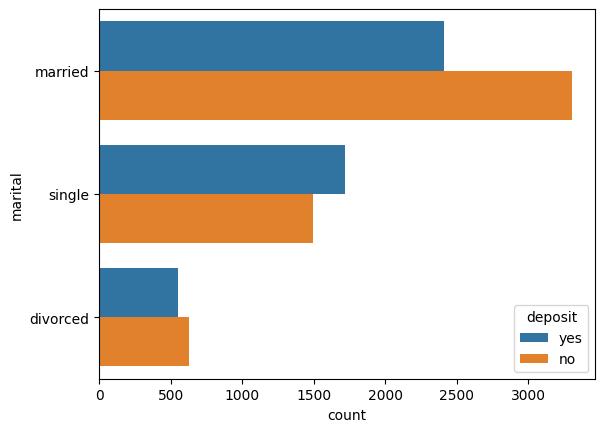

In [209]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
sns.countplot(y='marital', hue='deposit', data=clean_df)

<AxesSubplot: xlabel='count', ylabel='education'>

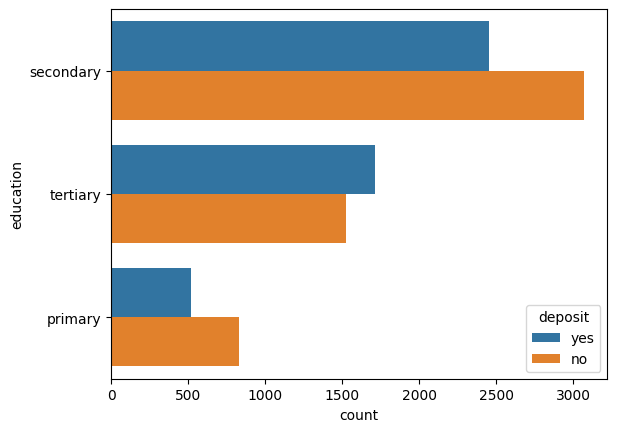

In [210]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
sns.countplot(y='education', hue='deposit', data=clean_df)

<AxesSubplot: xlabel='count', ylabel='job'>

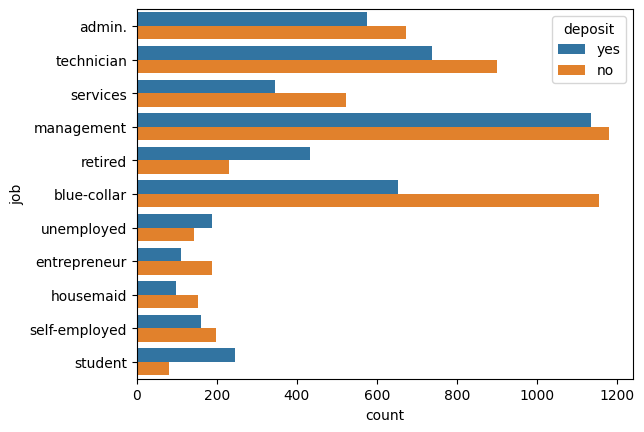

In [211]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
sns.countplot(y='job', hue='deposit', data=clean_df)

### Задание 11

marital    divorced  married  single
education                           
primary          96      339      82
secondary       283     1289     879
tertiary        174      784     755


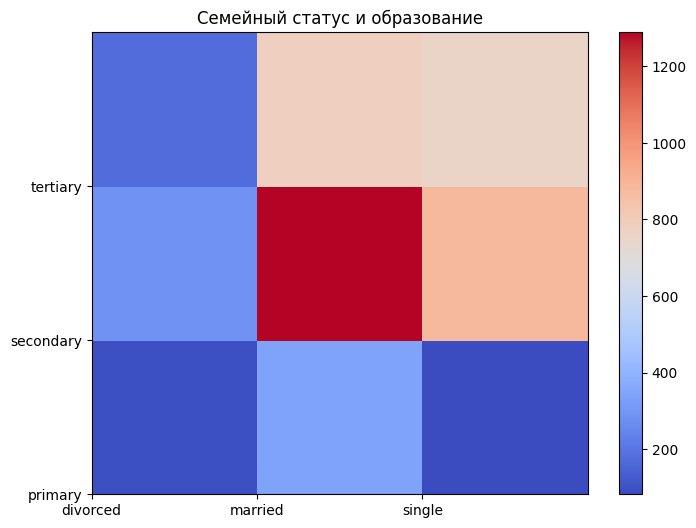

In [212]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
agree_to_deposit = clean_df.loc[clean_df['deposit'] == 'yes']
# Используем crosstab() для создания кросс-таблицы
cross_table = pd.crosstab(agree_to_deposit['education'], agree_to_deposit['marital'])
print(cross_table)
# Визуализируем тепловую карту
plt.figure(figsize=(8, 6))
plt.title('Cемейный статус и образование')
heatmap = plt.pcolor(cross_table, cmap='coolwarm')

# Добавляем подписи к осям
plt.xticks(range(len(cross_table.columns)), cross_table.columns)
plt.yticks(range(len(cross_table.index)), cross_table.index)

# Добавляем цветовую шкалу
plt.colorbar(heatmap)

plt.show()

## Часть 3: преобразование данных

### Задание 1

In [213]:
# преобразуйте уровни образования
# Инициализируем LabelEncoder
label_encoder = LabelEncoder()

# Применим LabelEncoder к столбцу 'education'
clean_df['education'] = label_encoder.fit_transform(clean_df['education'])
clean_df['education'].sum()

11995

In [214]:
clean_df['age_group'] = label_encoder.fit_transform(clean_df['age_group'])

### Задания 2 и 3

In [215]:
# преобразуйте бинарные переменные в представление из нулей и единиц
clean_df['deposit'] = clean_df['deposit'].apply(lambda x: 1 if x == 'yes' else 0)
round(clean_df['deposit'].std(), 3)

0.499

In [216]:
clean_df['default'] = clean_df['default'].apply(lambda x: 1 if x == 'yes' else 0)
clean_df['housing'] = clean_df['housing'].apply(lambda x: 1 if x == 'yes' else 0)
clean_df['loan'] = clean_df['loan'].apply(lambda x: 1 if x == 'yes' else 0)
res = clean_df['default'].mean()+clean_df['housing'].mean()+clean_df['loan'].mean()
round(res, 3)

0.635

### Задание 4

In [217]:
# создайте дамми-переменные
df_d = pd.get_dummies(clean_df, columns=['job', 'marital', 'contact', 'month', 'poutcome'])
df_d.shape

(10105, 46)

### Задания 5 и 6

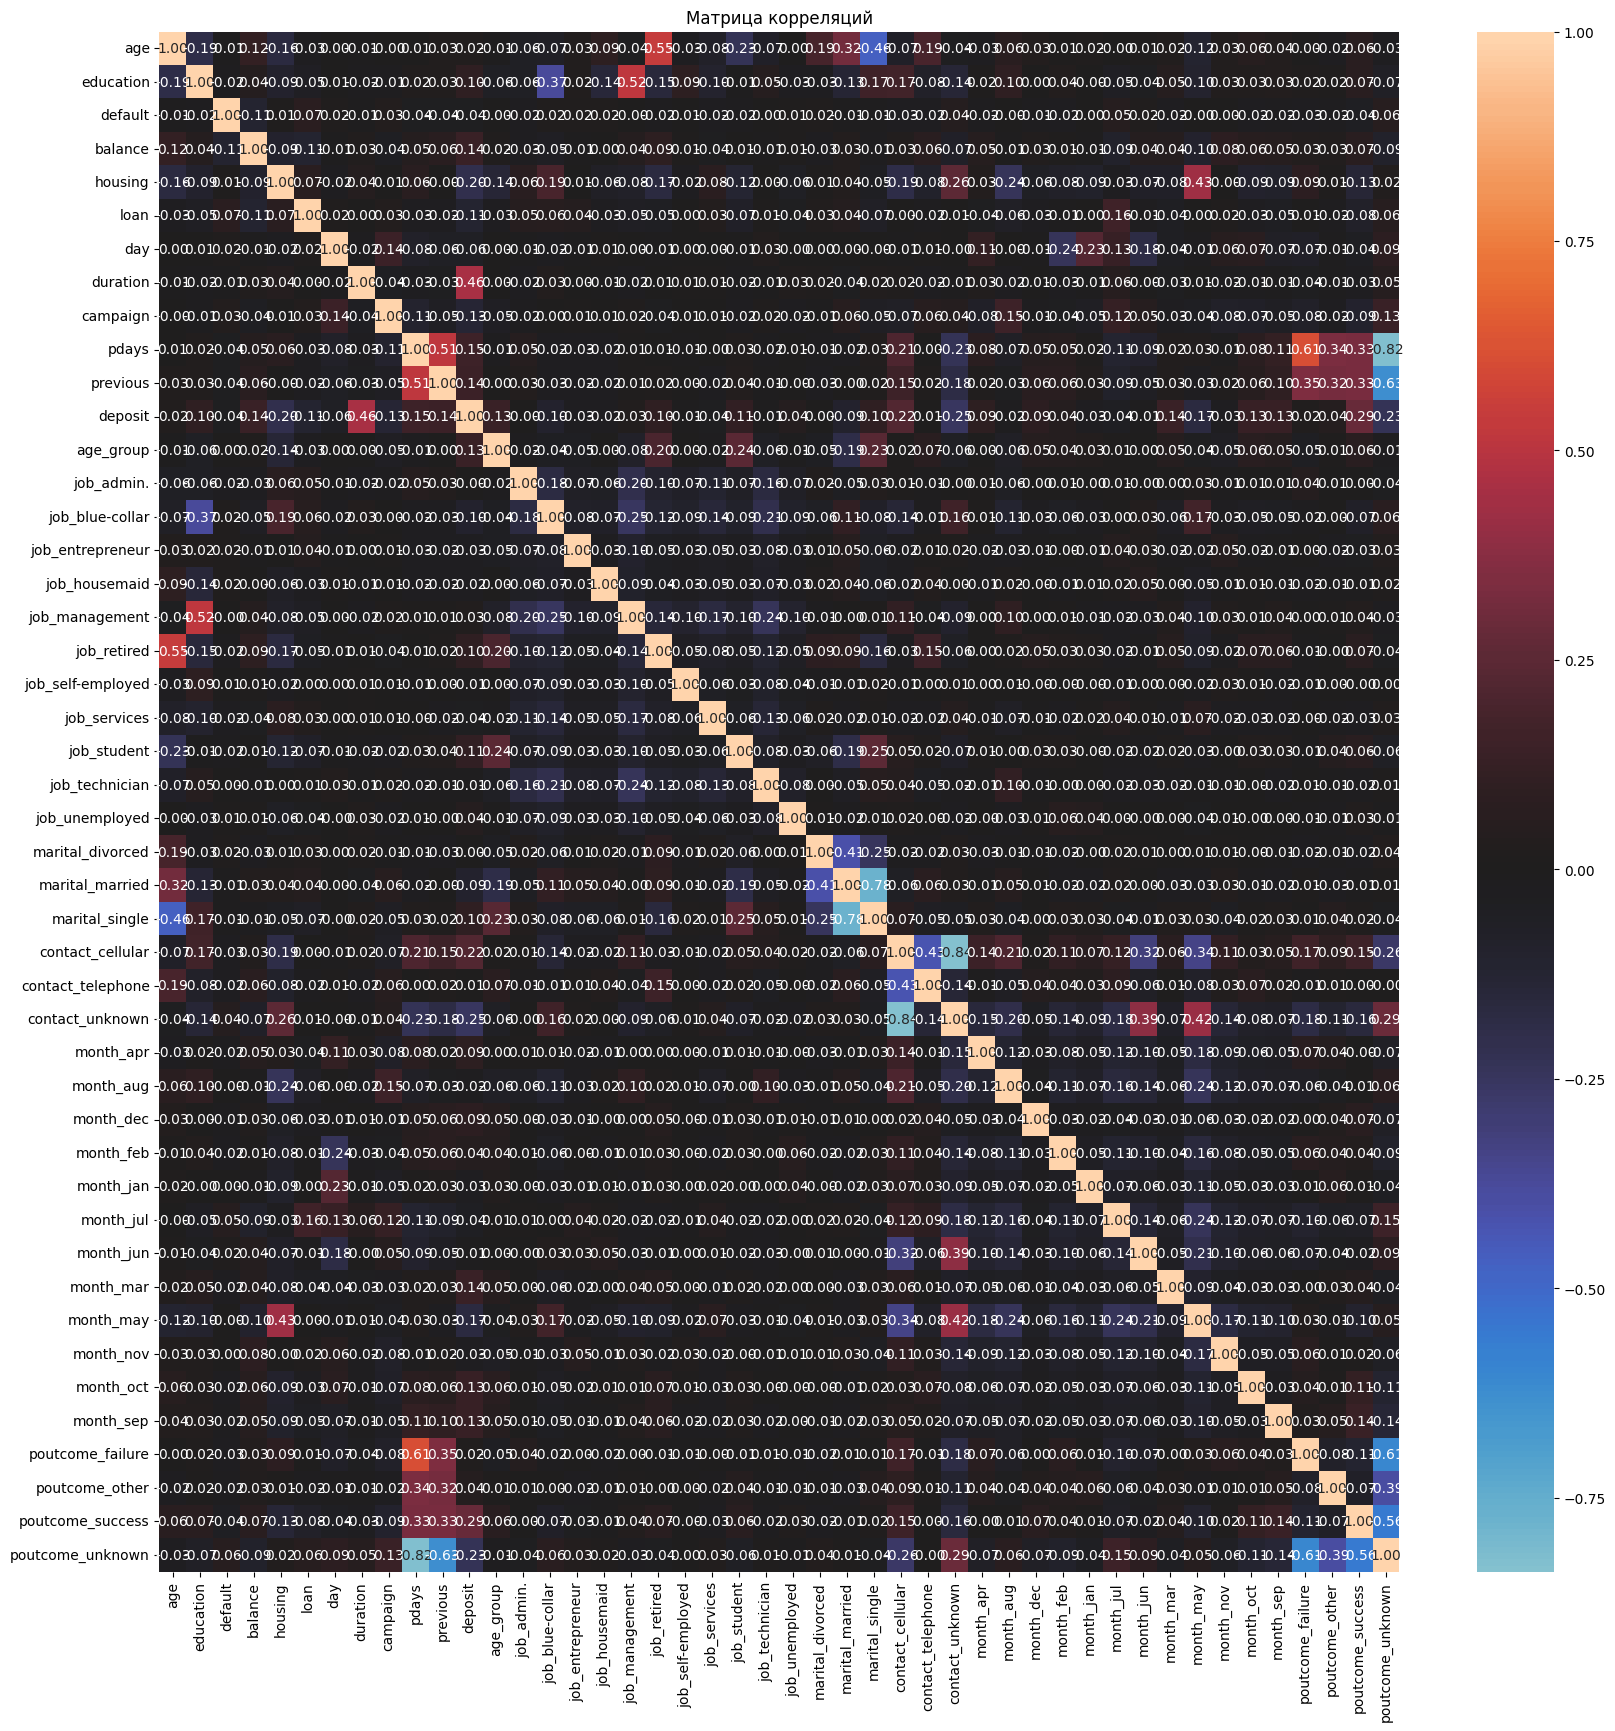

In [218]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
# Считаем матрицу корреляций
correlation_matrix = df_d.corr()

# Рисуем тепловую карту
plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, fmt='.2f',annot=True, center=0)
plt.title('Матрица корреляций')
plt.show()

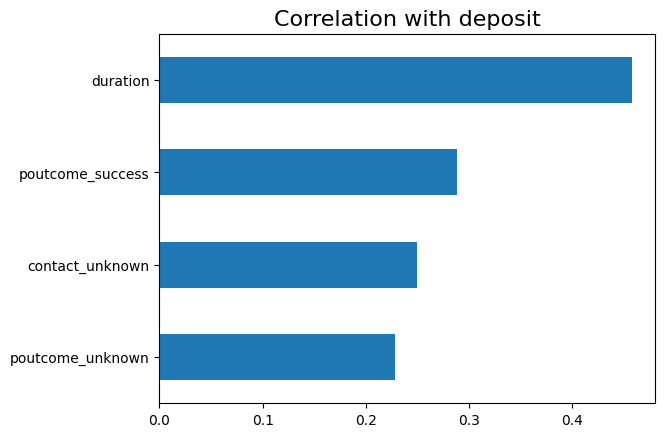

In [219]:
correlation_matrix["deposit"].apply(lambda x: abs(x)).sort_values()[-5:-1].plot.barh()
plt.title("Correlation with deposit", fontsize = 16)
plt.show()

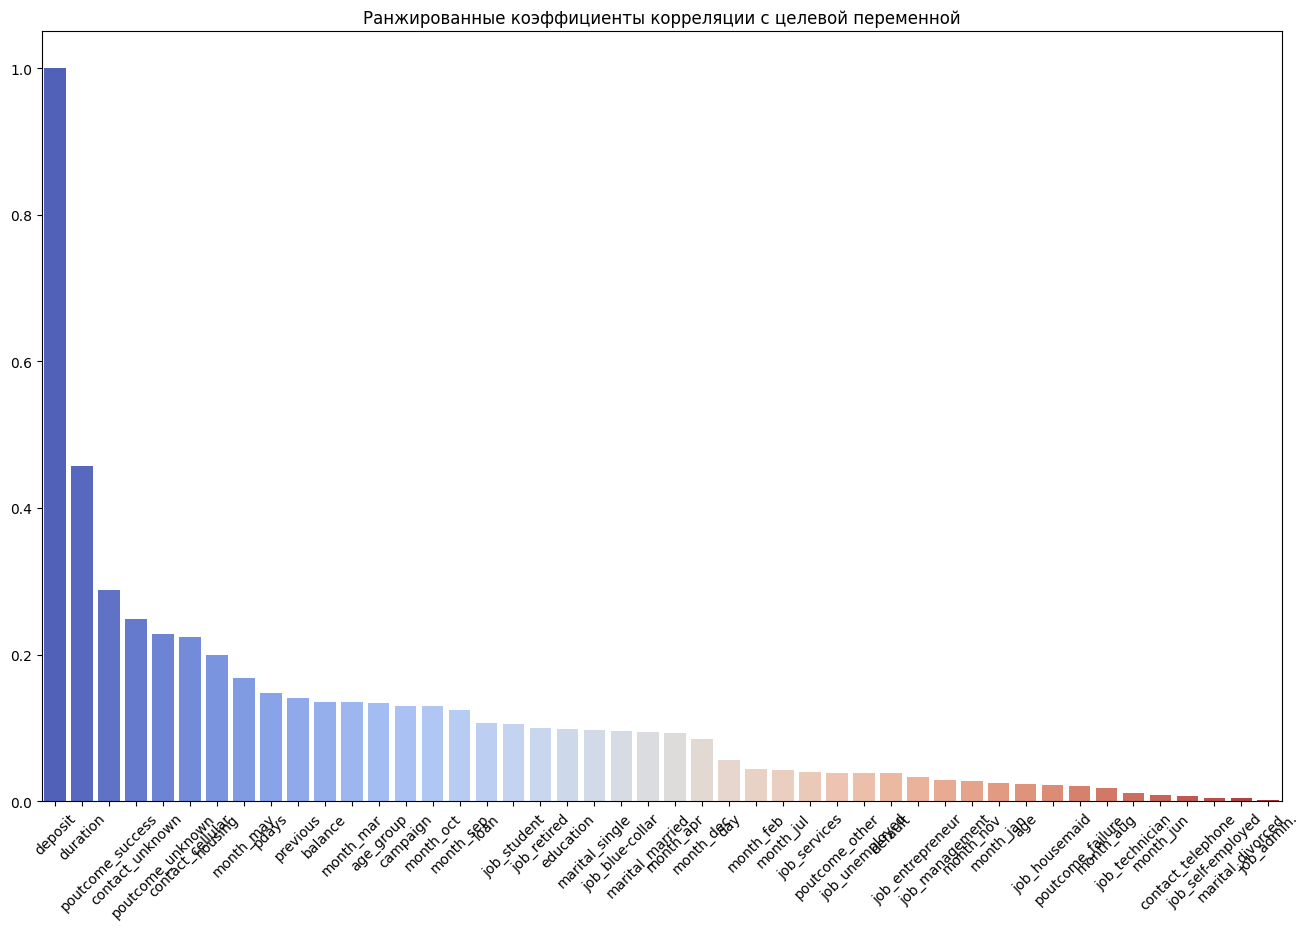

In [220]:
# Сортируем коэффициенты корреляции с целевой переменной по абсолютному значению
correlation_with_target = correlation_matrix['deposit'].abs().sort_values(ascending=False)

# Рисуем столбчатую диаграмму
plt.figure(figsize=(16, 10))
sns.barplot(x=correlation_with_target.index, y=correlation_with_target.values, palette='coolwarm')
plt.title('Ранжированные коэффициенты корреляции с целевой переменной')
plt.xticks(rotation=45)
plt.show()

### Задания 7 и 8

In [221]:
X = df_d.drop(['deposit'], axis=1)
y = df_d['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [223]:
# рассчитайте необходимые показатели
X_test.shape[0]
round(y_test.mean(), 2)

0.46

### Задание 9

In [224]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
# Инициализируем SelectKBest с метрикой f_classif и указываем k=15 (15 лучших признаков)
selector = SelectKBest(f_classif, k=15)

# Применяем SelectKBest к обучающей выборке
X_train_selected = selector.fit_transform(X_train, y_train)

# Получаем индексы отобранных признаков
selected_indices = selector.get_support(indices=True)

# Получаем имена отобранных признаков
selected_features = X_train.columns[selected_indices]

# Выводим имена отобранных признаков
print("Отобранные признаки:")
print(selected_features)

Отобранные признаки:
Index(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')


In [225]:
df_b = df_d[['balance', 'housing', 'duration', 'campaign', 'pdays', 
         'previous', 'age_group', 'contact_cellular', 'contact_unknown',
         'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown', 'deposit']]

X = df_b.drop(['deposit'], axis=1)
y = df_b['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

### Задание 10

In [227]:
# нормализуйте данные с помощью minmaxsxaler
from sklearn.preprocessing import MinMaxScaler
# Инициализируем MinMaxScaler
scaler = MinMaxScaler()

# Применяем MinMaxScaler к обучающей выборке
X_train_scaled = scaler.fit_transform(X_train)

# Применяем тот же scaler к тестовой выборке (НЕ fit_transform!)
X_test_scaled = scaler.transform(X_test)

In [229]:
mean_first_predictor = X_test_scaled[:, 0].mean()

# Округляем до двух знаков после точки-разделителя
mean_first_predictor_rounded = round(mean_first_predictor, 2)

print(f"Среднее арифметическое для первого предиктора: {mean_first_predictor_rounded}")

Среднее арифметическое для первого предиктора: 0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [231]:
# обучите логистическую регрессию и рассчитайте метрики качества
# Создаем и обучаем модель логистической регрессии
log_reg = linear_model.LogisticRegression(
    solver='sag', 
    random_state=42, 
    max_iter=1000 )

log_reg.fit(X_train_scaled, y_train)

# Предсказываем значения для тестовой выборки
y_pred = log_reg.predict(X_test_scaled)

# Рассчитываем accuracy
from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(y_test, y_pred)

# Округляем до двух знаков после точки-разделителя
accuracy_rounded = round(accuracy, 2)

print(f"Accuracy на тестовой выборке: {accuracy_rounded}")

Accuracy на тестовой выборке: 0.81


### Задания 2,3,4

In [232]:
# обучите решающие деревья, настройте максимальную глубину
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Инициализируем списки для сохранения значений accuracy на обучающей и тестовой выборках
train_accuracies = []
test_accuracies = []

# Задаем диапазон глубин дерева, который вы хотите перебрать
depths_to_try = range(1, 11)  # Пример: от 1 до 10

for depth in depths_to_try:
    # Создаем и обучаем модель решающего дерева
    tree_model = DecisionTreeClassifier(max_depth=depth)
    tree_model.fit(X_train_scaled, y_train)

    # Предсказываем значения на обучающей и тестовой выборках
    y_train_pred = tree_model.predict(X_train_scaled)
    y_test_pred = tree_model.predict(X_test_scaled)

    # Рассчитываем accuracy на обучающей и тестовой выборках
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Добавляем значения accuracy в списки
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Находим глубину с максимальным значением accuracy на тестовой выборке
optimal_depth = depths_to_try[test_accuracies.index(max(test_accuracies))]

print(f"Оптимальная глубина дерева: {optimal_depth}")
print(f"Максимальное значение accuracy на тестовой выборке: {max(test_accuracies):.2f}")


Оптимальная глубина дерева: 7
Максимальное значение accuracy на тестовой выборке: 0.81


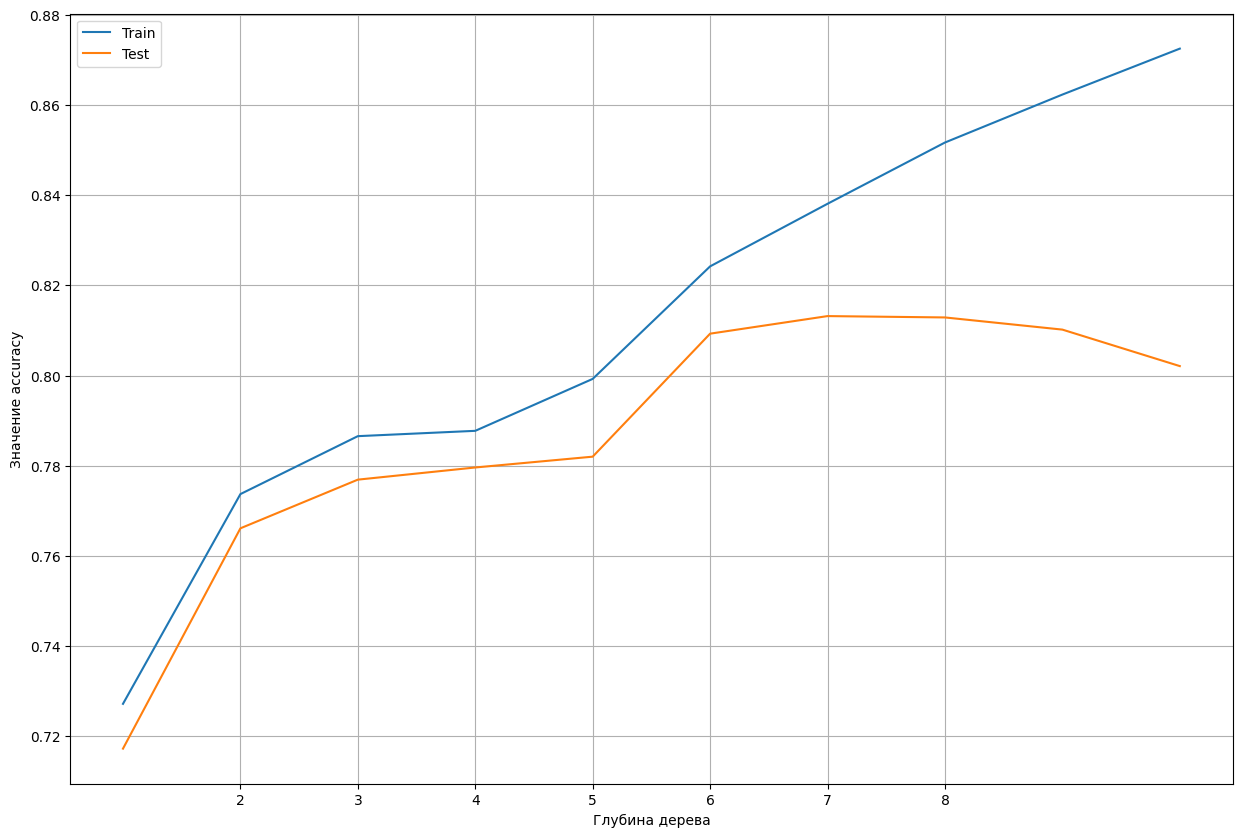

In [233]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(depths_to_try, train_accuracies, label='Train')
ax.plot(depths_to_try, test_accuracies, label='Test')
ax.set_xlabel('Глубина дерева')
ax.set_ylabel('Значение accuracy')
ax.xaxis.set_ticks(depths)
ax.grid()
ax.legend()

Лучшая метрика на глубине 7, но 6 очень близко пр метрике, а дельта с тренировочной меньше, то есть переобучение меньше. Поэтому берем глубину 6.

In [234]:
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth = 6
)

dt.fit(X_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)

### Задание 5

In [236]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV
# Создаем DataFrame с параметрами
param_grid = {
    'min_samples_split': [2, 5, 7, 10],
    'max_depth': [3, 5, 7]
}

# Создаем модель. Инициализируем GridSearch
model_cv = GridSearchCV(tree.DecisionTreeClassifier(), 
                        param_grid,
                        cv=3, scoring=('f1'), 
                        return_train_score=True)

# Запускаем поиск лучших параметров
model_cv.fit(X_train_scaled, y_train)

print("accuracy на тестовом наборе: {:.2f}".format(model_cv.score(X_test_scaled, y_test)))
y_test_pred = grid_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(model_cv.best_params_))

accuracy на тестовом наборе: 0.80
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 2}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [237]:
# обучите на ваших данных случайный лес
from sklearn.ensemble import RandomForestClassifier
# Создадим модель случайного леса с заданными параметрами
model = RandomForestClassifier(n_estimators=100,
                               criterion='gini',
                               min_samples_leaf=5,
                               max_depth=10,
                               random_state=42)

# Обучим модель
model.fit(X_train_scaled, y_train)

y_test_pred = model.predict(X_test_scaled)

# Рассчитываем метрику accuracy
accuracy = accuracy_score(y_test, y_test_pred)
from sklearn.metrics import recall_score
# Рассчитываем метрику recall
recall = recall_score(y_test, y_test_pred)

# Выводим результаты
print(f'Accuracy: {round(accuracy, 2)}')
print(f'Recall: {round(recall, 2)}')

Accuracy: 0.83
Recall: 0.83


### Задания 2 и 3

In [238]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier
# Создадим модель градиентного бустинга с заданными параметрами
model = GradientBoostingClassifier(learning_rate=0.05,
                                   n_estimators=300,
                                   min_samples_leaf=5,
                                   max_depth=5,
                                   random_state=42)

# Обучим модель
model.fit(X_train_scaled, y_train)

y_test_pred = model.predict(X_test_scaled)

print(f'F1: {round(f1_score(y_test, y_test_pred), 2)}')
print(f'Accuracy: {round(accuracy_score(y_test, y_test_pred), 2)}')
print(f'Recall: {round(recall_score(y_test, y_test_pred), 2)}')

F1: 0.82
Accuracy: 0.83
Recall: 0.83


### Задание 4

In [239]:
# объедините уже известные вам алгоритмы с помощью стекинга 
# определим три базовых алгоритма для стекинга
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]
# создадим стекинг модель с использованием StackingClassifier. В качестве базовых моделей используются три алгоритма из estimators, а в качестве метамодели используется логистическая регрессия
stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
# обучим модель
stack.fit(X_train_scaled, y_train)
from sklearn.metrics import precision_score
# Получаем предсказания стекинг модели на тестовой выборке
y_pred = stack.predict(X_test_scaled)
print(f'Precision: {round(precision_score(y_test, y_pred), 2)}')

Precision: 0.81


### Задание 5

In [240]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
# Получим названия признаков
gb = ensemble.GradientBoostingClassifier()

# Обучаем модель на данных
gb.fit(X_train_scaled, y_train)

# Извлекаем важности признаков
importance = gb.feature_importances_
# Создаем DataFrame с названиями признаков и их важностями
feature_importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': importance})

# Отсортируем по важности в убывающем порядке
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Выведем топ-10 важных признаков
top_features = feature_importance_df.head(10)

print(top_features)


             Feature  Importance
2           duration    0.564756
13  poutcome_success    0.123935
8    contact_unknown    0.075185
1            housing    0.054843
4              pdays    0.040751
6          age_group    0.031777
9          month_mar    0.030120
0            balance    0.021647
11         month_oct    0.019259
12         month_sep    0.013435


### Задания 6,7,8

In [243]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna
def objective(trial):
    # Определяем пространство поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

    # Создаем модель случайного леса с выбранными гиперпараметрами
    rf_model = RandomForestClassifier(n_estimators=n_estimators,
                                      max_depth=max_depth,
                                      min_samples_leaf=min_samples_leaf,
                                      random_state=42)

    # Обучаем модель
    rf_model.fit(X_train_scaled, y_train)

    # Получаем предсказания на тестовой выборке
    y_pred = rf_model.predict(X_test_scaled)

    # Вычисляем метрику F1
    f1 = f1_score(y_test, y_pred)

    return f1

# Создаем объект study для оптимизации
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Получаем лучшие параметры
best_params = study.best_params

# Используем лучшие параметры для обучения финальной модели
best_rf_model = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_depth=best_params['max_depth'],
    min_samples_leaf=best_params['min_samples_leaf'],
    random_state=42
)
best_rf_model.fit(X_train_scaled, y_train)

# Оценка метрик на тестовой выборке
y_pred = best_rf_model.predict(X_test_scaled)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Округляем результаты до двух знаков после запятой
f1 = round(f1, 2)
accuracy = round(accuracy, 2)

print(f'F1 Score: {f1}')
print(f'Accuracy: {accuracy}')

[I 2023-09-27 13:06:20,826] A new study created in memory with name: no-name-df5450e3-948e-493b-990b-501551845a30
[I 2023-09-27 13:06:22,066] Trial 0 finished with value: 0.8197857592942659 and parameters: {'n_estimators': 162, 'max_depth': 13, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8197857592942659.
[I 2023-09-27 13:06:22,783] Trial 1 finished with value: 0.8186104998428169 and parameters: {'n_estimators': 101, 'max_depth': 29, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8197857592942659.
[I 2023-09-27 13:06:23,715] Trial 2 finished with value: 0.8203517587939699 and parameters: {'n_estimators': 127, 'max_depth': 26, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.8203517587939699.
[I 2023-09-27 13:06:24,601] Trial 3 finished with value: 0.815399179551909 and parameters: {'n_estimators': 105, 'max_depth': 29, 'min_samples_leaf': 2}. Best is trial 2 with value: 0.8203517587939699.
[I 2023-09-27 13:06:25,847] Trial 4 finished with value: 0.8188976377952755

F1 Score: 0.82
Accuracy: 0.83
